# Agent: code gen and reflection

**Overview:** Use an agent to generate code, and another to critique

**Steps:**

1) **Load and prepare data** — via `utils.load_and_prepare_data(...)`.  
2) **Generate V1 code** — with `generate_chart_code(...)`, which returns the first-draft matplotlib code (wrapped in `<execute_python>` tags).  
3) **Execute V1 immediately** — the workflow extracts the code between `<execute_python>` tags and runs it to produce the first chart image.  
4) **Reflect and refine** — `reflect_on_image_and_regenerate(...)` critiques the V1 image (and the original code) against the instruction, returns concise **feedback** plus **revised code (V2)**.  
5) **Execute V2 immediately** — the refined code is extracted and executed to generate the improved chart.

## 0. Initialization

### Import

In [2]:
# Standard library imports
import re
import json

# Local helper module
import utils

In [ ]:
# Test the get_response function
model = "gemini-2.5-flash"
prompt = "Say hello world!"
response = utils.get_response(model, prompt)
response

'Hello world!'

### Load data

In [4]:
# Load data into a dataframe
df = utils.load_and_prepare_data('coffee_sales.csv')

# Grab a random sample to display
utils.print_html(df.sample(n=5), title="Random Sample of Coffee Sales Data")

date,time,cash_type,card,price,coffee_name,quarter,month,year
2024-12-19,14:07,card,ANON-0000-0000-1020,3.576,Hot Chocolate,4,12,2024
2024-03-12,10:31,card,ANON-0000-0000-0004,3.380,Americano with Milk,1,3,2024
2024-09-28,17:30,card,ANON-0000-0000-0687,3.576,Hot Chocolate,3,9,2024
2024-11-03,16:45,card,ANON-0000-0000-0852,2.596,Americano,4,11,2024
2025-03-05,08:24,card,ANON-0000-0000-1184,3.576,Cappuccino,1,3,2025


## 1. Generate initial code

In [5]:
def generate_chart_code(instruction: str, model: str, out_path_v1: str) -> str:
    """Generate Python code to make a plot with matplotlib using tag-based wrapping."""

    prompt = f"""
    You are a data visualization expert.

    Return your answer *strictly* in this format:

    <execute_python>
    # valid python code here
    </execute_python>

    Do not add explanations, only the tags and the code.

    The code should create a visualization from a DataFrame 'df' with these columns:
    - date (M/D/YY)
    - time (HH:MM)
    - cash_type (card or cash)
    - card (string)
    - price (number)
    - coffee_name (string)
    - quarter (1-4)
    - month (1-12)
    - year (YYYY)

    User instruction: {instruction}

    Requirements for the code:
    1. Assume the DataFrame is already loaded as 'df'.
    2. Use matplotlib for plotting.
    3. Add clear title, axis labels, and legend if needed.
    4. Save the figure as '{out_path_v1}' with dpi=300.
    5. Do not call plt.show().
    6. Close all plots with plt.close().
    7. Add all necessary import python statements

    Return ONLY the code wrapped in <execute_python> tags.
    """

    response = utils.get_response(model, prompt)
    return response

## 2. Execute code

In [ ]:
def extract_code_from_tags(code: str, tag: str) -> str:
    """Extract code within specified tags."""
    pattern = fr"<{tag}>([\s\S]*?)</{tag}>"
    match = re.search(pattern, code)
    if match:
        return match.group(1).strip()
    return ""

In [17]:
def execute_code(code: str, exec_globals: dict):
    """Execute the provided code string in the given global context."""
    exec(code, exec_globals)

## 3. Reflect and refine

In [10]:
def reflect_on_image_and_regenerate(
    chart_path: str,
    instruction: str,
    model_name: str,
    out_path_v2: str,
    code_v1: str,  
) -> tuple[str, str]:
    """
    Critique the chart IMAGE and the original code against the instruction, 
    then return refined matplotlib code.
    Returns (feedback, refined_code_with_tags).
    Supports OpenAI and Anthropic (Claude).
    """
    # media_type, b64 = utils.encode_image_b64(chart_path)
    with open(chart_path, 'rb') as f:
        image_bytes = f.read()

    prompt = f"""
    You are a data visualization expert.
    Your task: critique the attached chart and the original code against the given instruction,
    then return improved matplotlib code.

    Original code (for context):
    {code_v1}

    OUTPUT FORMAT (STRICT!):
    1) First line: a valid JSON object with ONLY the "feedback" field.
    Example: {{"feedback": "The legend is unclear and the axis labels overlap."}}

    2) After a newline, output ONLY the refined Python code wrapped in:
    <execute_python>
    ...
    </execute_python>

    3) Import all necessary libraries in the code. Don't assume any imports from the original code.

    HARD CONSTRAINTS:
    - Do NOT include Markdown, backticks, or any extra prose outside the two parts above.
    - Use pandas/matplotlib only (no seaborn).
    - Assume df already exists; do not read from files.
    - Save to '{out_path_v2}' with dpi=300.
    - Always call plt.close() at the end (no plt.show()).
    - Include all necessary import statements.

    Schema (columns available in df):
    - date (M/D/YY)
    - time (HH:MM)
    - cash_type (card or cash)
    - card (string)
    - price (number)
    - coffee_name (string)
    - quarter (1-4)
    - month (1-12)
    - year (YYYY)

    Instruction:
    {instruction}
    """

    # In case the name is "Claude" or "Anthropic", use the safe helper
    lower = model_name.lower()

    # ✅ Use the safe helper that joins all text blocks and adds a system prompt
    if "gemini" in lower or "google" in lower:
        content = utils.image_gemini_call(model_name, prompt, image_bytes)
    # if "claude" in lower or "anthropic" in lower:
    #     content = utils.image_anthropic_call(model_name, prompt, media_type, b64)
    # else:
    #     content = utils.image_openai_call(model_name, prompt, media_type, b64)

    # --- Parse ONLY the first JSON line (feedback) ---
    lines = content.strip().splitlines()
    json_line = lines[0].strip() if lines else ""

    try:
        obj = json.loads(json_line)
    except Exception as e:
        # Fallback: try to capture the first {...} in all the content
        m_json = re.search(r"\{.*?\}", content, flags=re.DOTALL)
        if m_json:
            try:
                obj = json.loads(m_json.group(0))
            except Exception as e2:
                obj = {"feedback": f"Failed to parse JSON: {e2}", "refined_code": ""}
        else:
            obj = {"feedback": f"Failed to find JSON: {e}", "refined_code": ""}

    # --- Extract refined code from <execute_python>...</execute_python> ---
    m_code = re.search(r"<execute_python>([\s\S]*?)</execute_python>", content)
    refined_code_body = m_code.group(1).strip() if m_code else ""
    refined_code = utils.ensure_execute_python_tags(refined_code_body)

    feedback = str(obj.get("feedback", "")).strip()
    return feedback, refined_code

## End-to-end pipeline

In [ ]:
def run_workflow(
    dataset_path: str,
    user_instruction: str,
    generation_model: str,
    reflection_model: str,   
    image_basename: str = "chart",
):
    """
    End-to-end pipeline:
      1) load dataset
      2) generate V1 code
      3) execute V1 → produce chart_v1.png
      4) reflect on V1 (image + original code) → feedback + refined code
      5) execute V2 → produce chart_v2.png

    Returns a dict with all artifacts (codes, feedback, image paths).
    """
    # 0) Load dataset; utils handles parsing and feature derivations (e.g., year/quarter)
    df = utils.load_and_prepare_data(dataset_path)
    utils.print_html(df.sample(n=5), title="Random Sample of Dataset")

    # Paths to store charts
    out_v1 = f"{image_basename}_v1.png"
    out_v2 = f"{image_basename}_v2.png"

    # 1) Generate code (V1)
    utils.print_html("Step 1: Generating chart code (V1)… 📈")
    code_v1 = generate_chart_code(
        instruction=user_instruction,
        model=generation_model,
        out_path_v1=out_v1,
    )
    utils.print_html(code_v1, title="LLM output with first draft code (V1)")

    # 2) Execute V1 (hard-coded: extract <execute_python> block and run immediately)
    utils.print_html("Step 2: Executing chart code (V1)… 💻")
    initial_code = extract_code_from_tags(code_v1, "execute_python")
    # utils.print_html(initial_code, title="Extracted Code to Execute")
    if initial_code:
        exec_globals = {"df": df}
        execute_code(initial_code, exec_globals)
        # If code run successfully, the file should have been generated
        utils.print_html(out_v1, is_image=True, title="Generated Chart (V1)")

    # 3) Reflect on V1 (image + original code) to get feedback and refined code (V2)
    utils.print_html("Step 3: Reflecting on V1 (image + code) and generating improvements… 🔁")
    feedback, code_v2 = reflect_on_image_and_regenerate(
        chart_path=out_v1,
        instruction=user_instruction,
        model_name=reflection_model,
        out_path_v2=out_v2,
        code_v1=code_v1,  # pass original code for context
    )
    utils.print_html(feedback, title="Reflection feedback on V1")
    utils.print_html(code_v2, title="LLM output with revised code (V2)")

    # 4) Execute V2 (hard-coded: extract <execute_python> block and run immediately)
    utils.print_html("Step 4: Executing refined chart code (V2)… 🖼️")
    reflected_code = extract_code_from_tags(code_v2, "execute_python")
    # utils.print_html(reflected_code, title="Extracted Code to Execute (V2)")
    if reflected_code:
        exec_globals = {"df": df}
        execute_code(reflected_code, exec_globals)
        # If code run successfully, the file should have been generated
        utils.print_html(out_v2, is_image=True, title="Regenerated Chart (V2)")

    return {
        "code_v1": code_v1,
        "chart_v1": out_v1,
        "feedback": feedback,
        "code_v2": code_v2,
        "chart_v2": out_v2,
    }

date,time,cash_type,card,price,coffee_name,quarter,month,year
2024-10-31,13:41,card,ANON-0000-0000-0276,3.086,Americano with Milk,4,10,2024
2024-10-11,16:40,card,ANON-0000-0000-0746,3.576,Hot Chocolate,4,10,2024
2025-02-06,11:36,card,ANON-0000-0000-1170,3.576,Cocoa,1,2,2025
2024-10-22,16:35,card,ANON-0000-0000-0507,3.576,Latte,4,10,2024
2024-04-05,09:14,card,ANON-0000-0000-0098,2.890,Cortado,2,4,2024



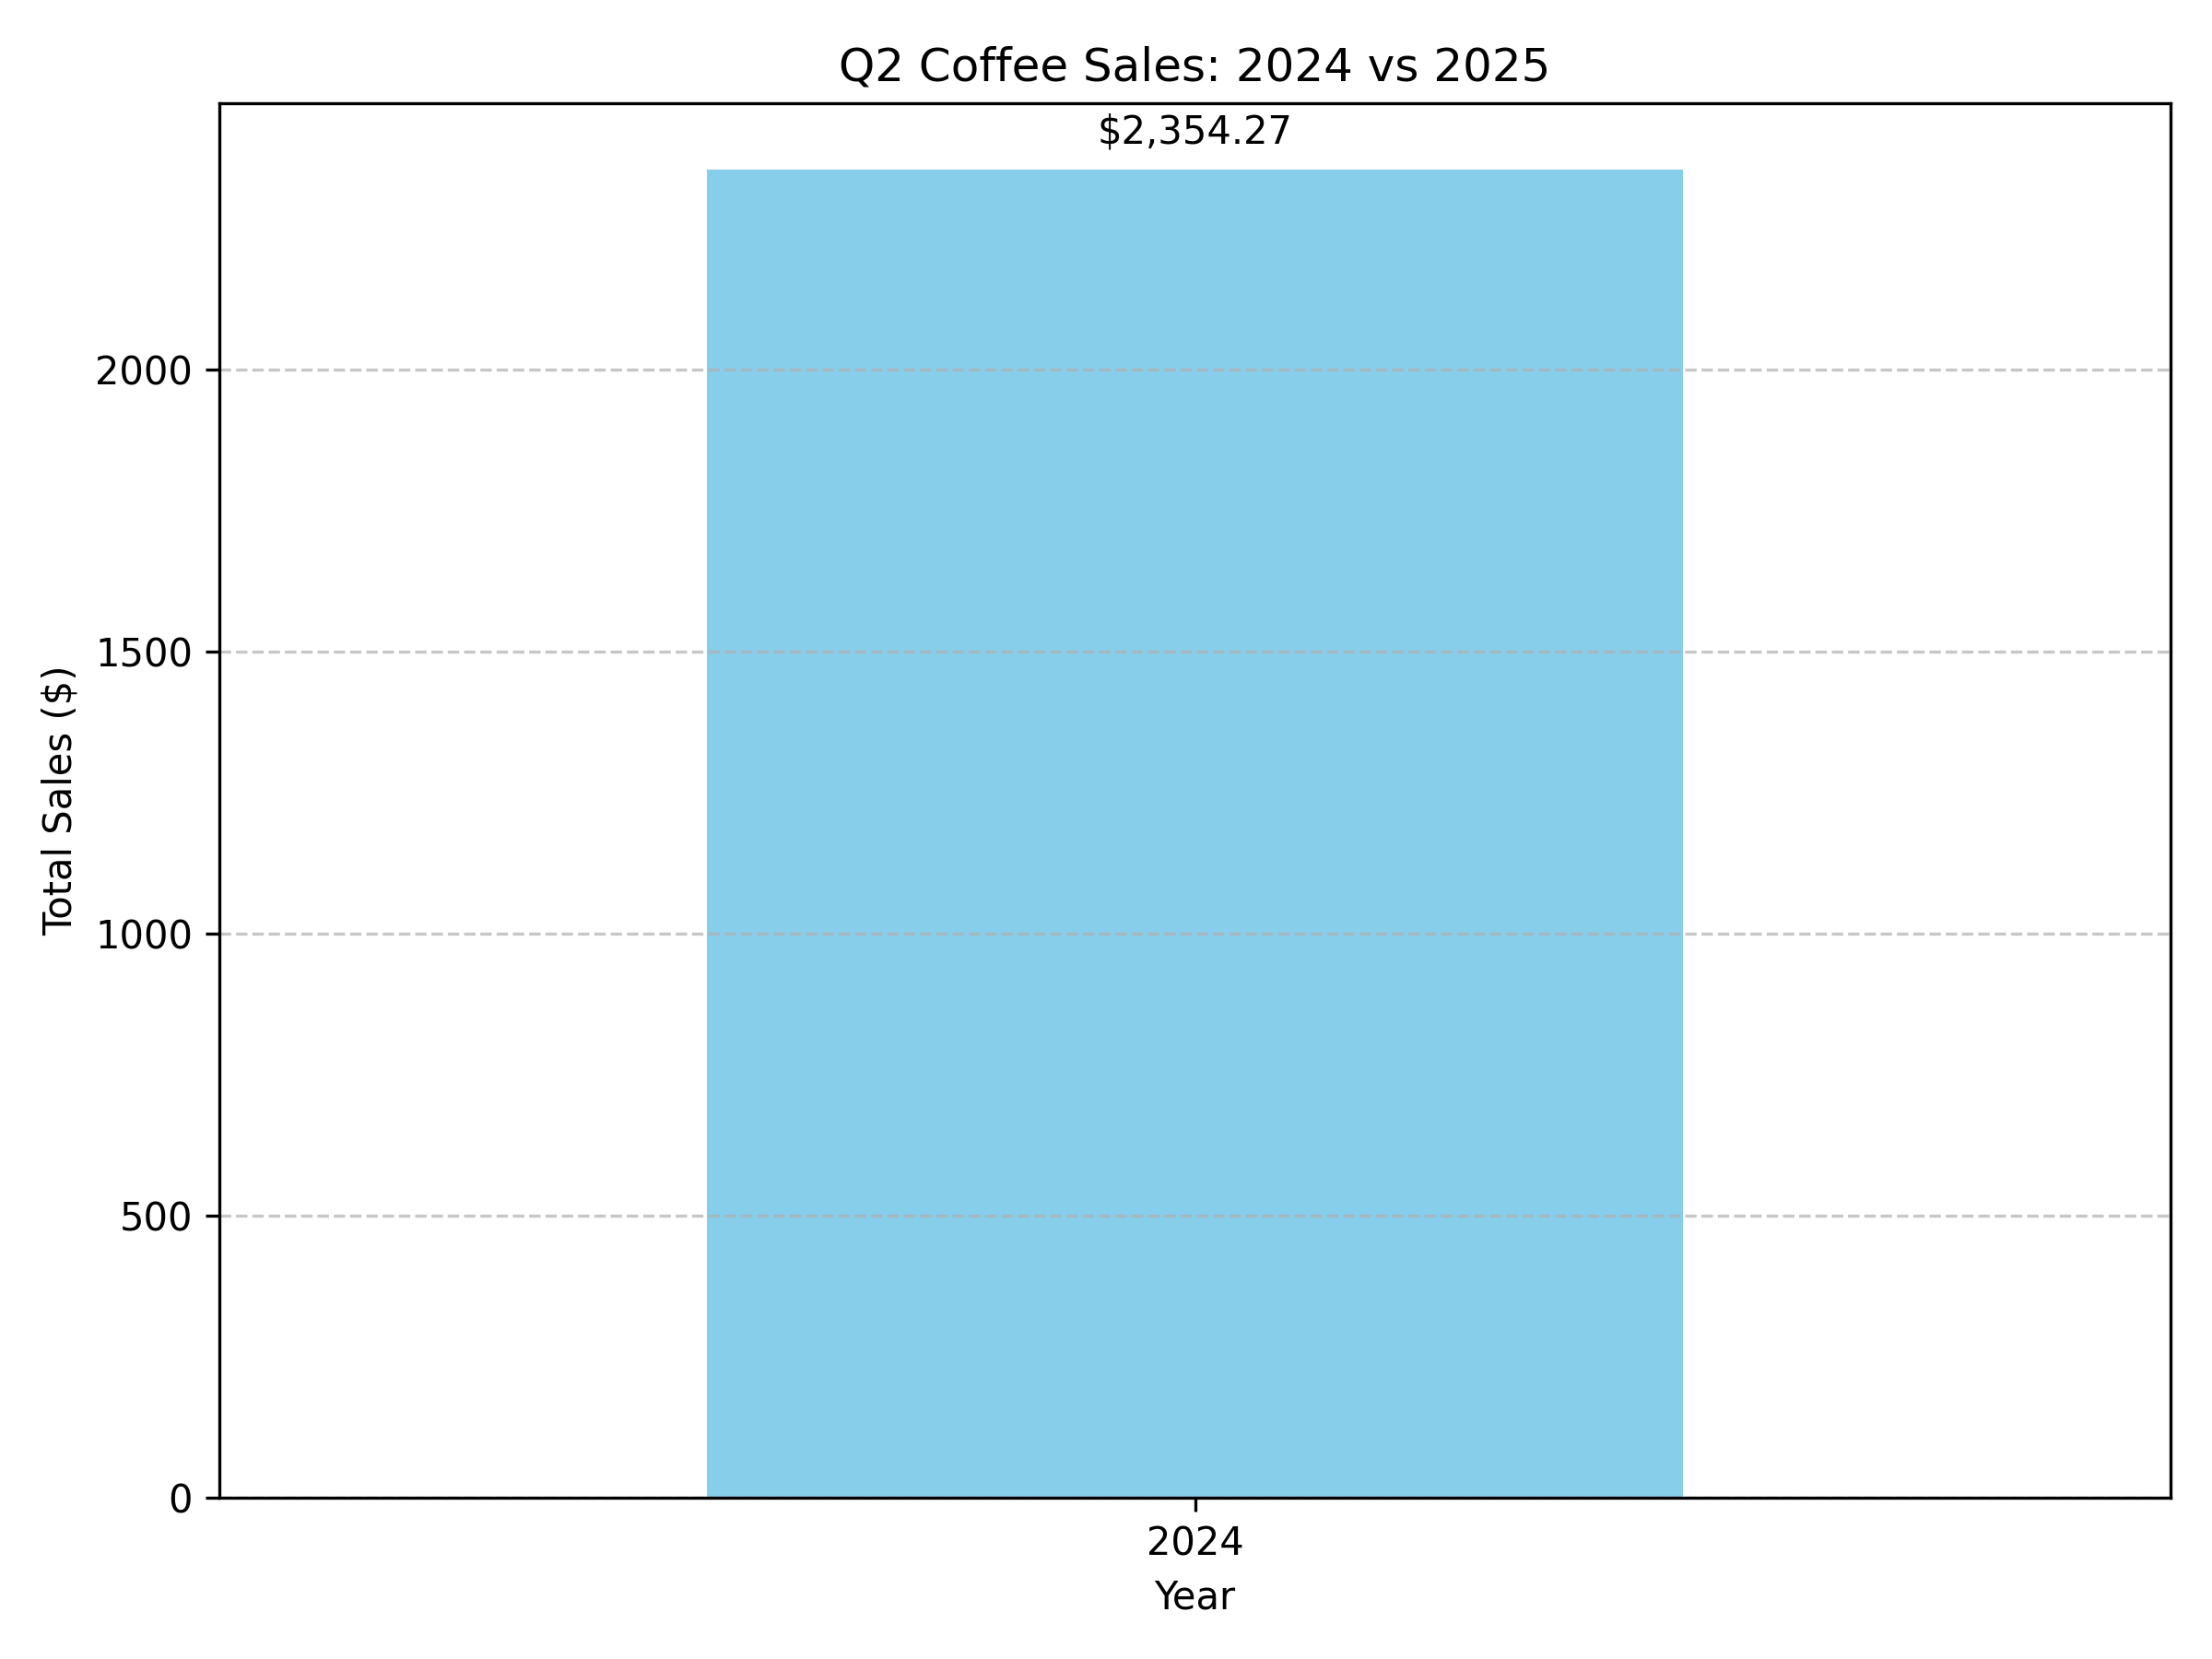


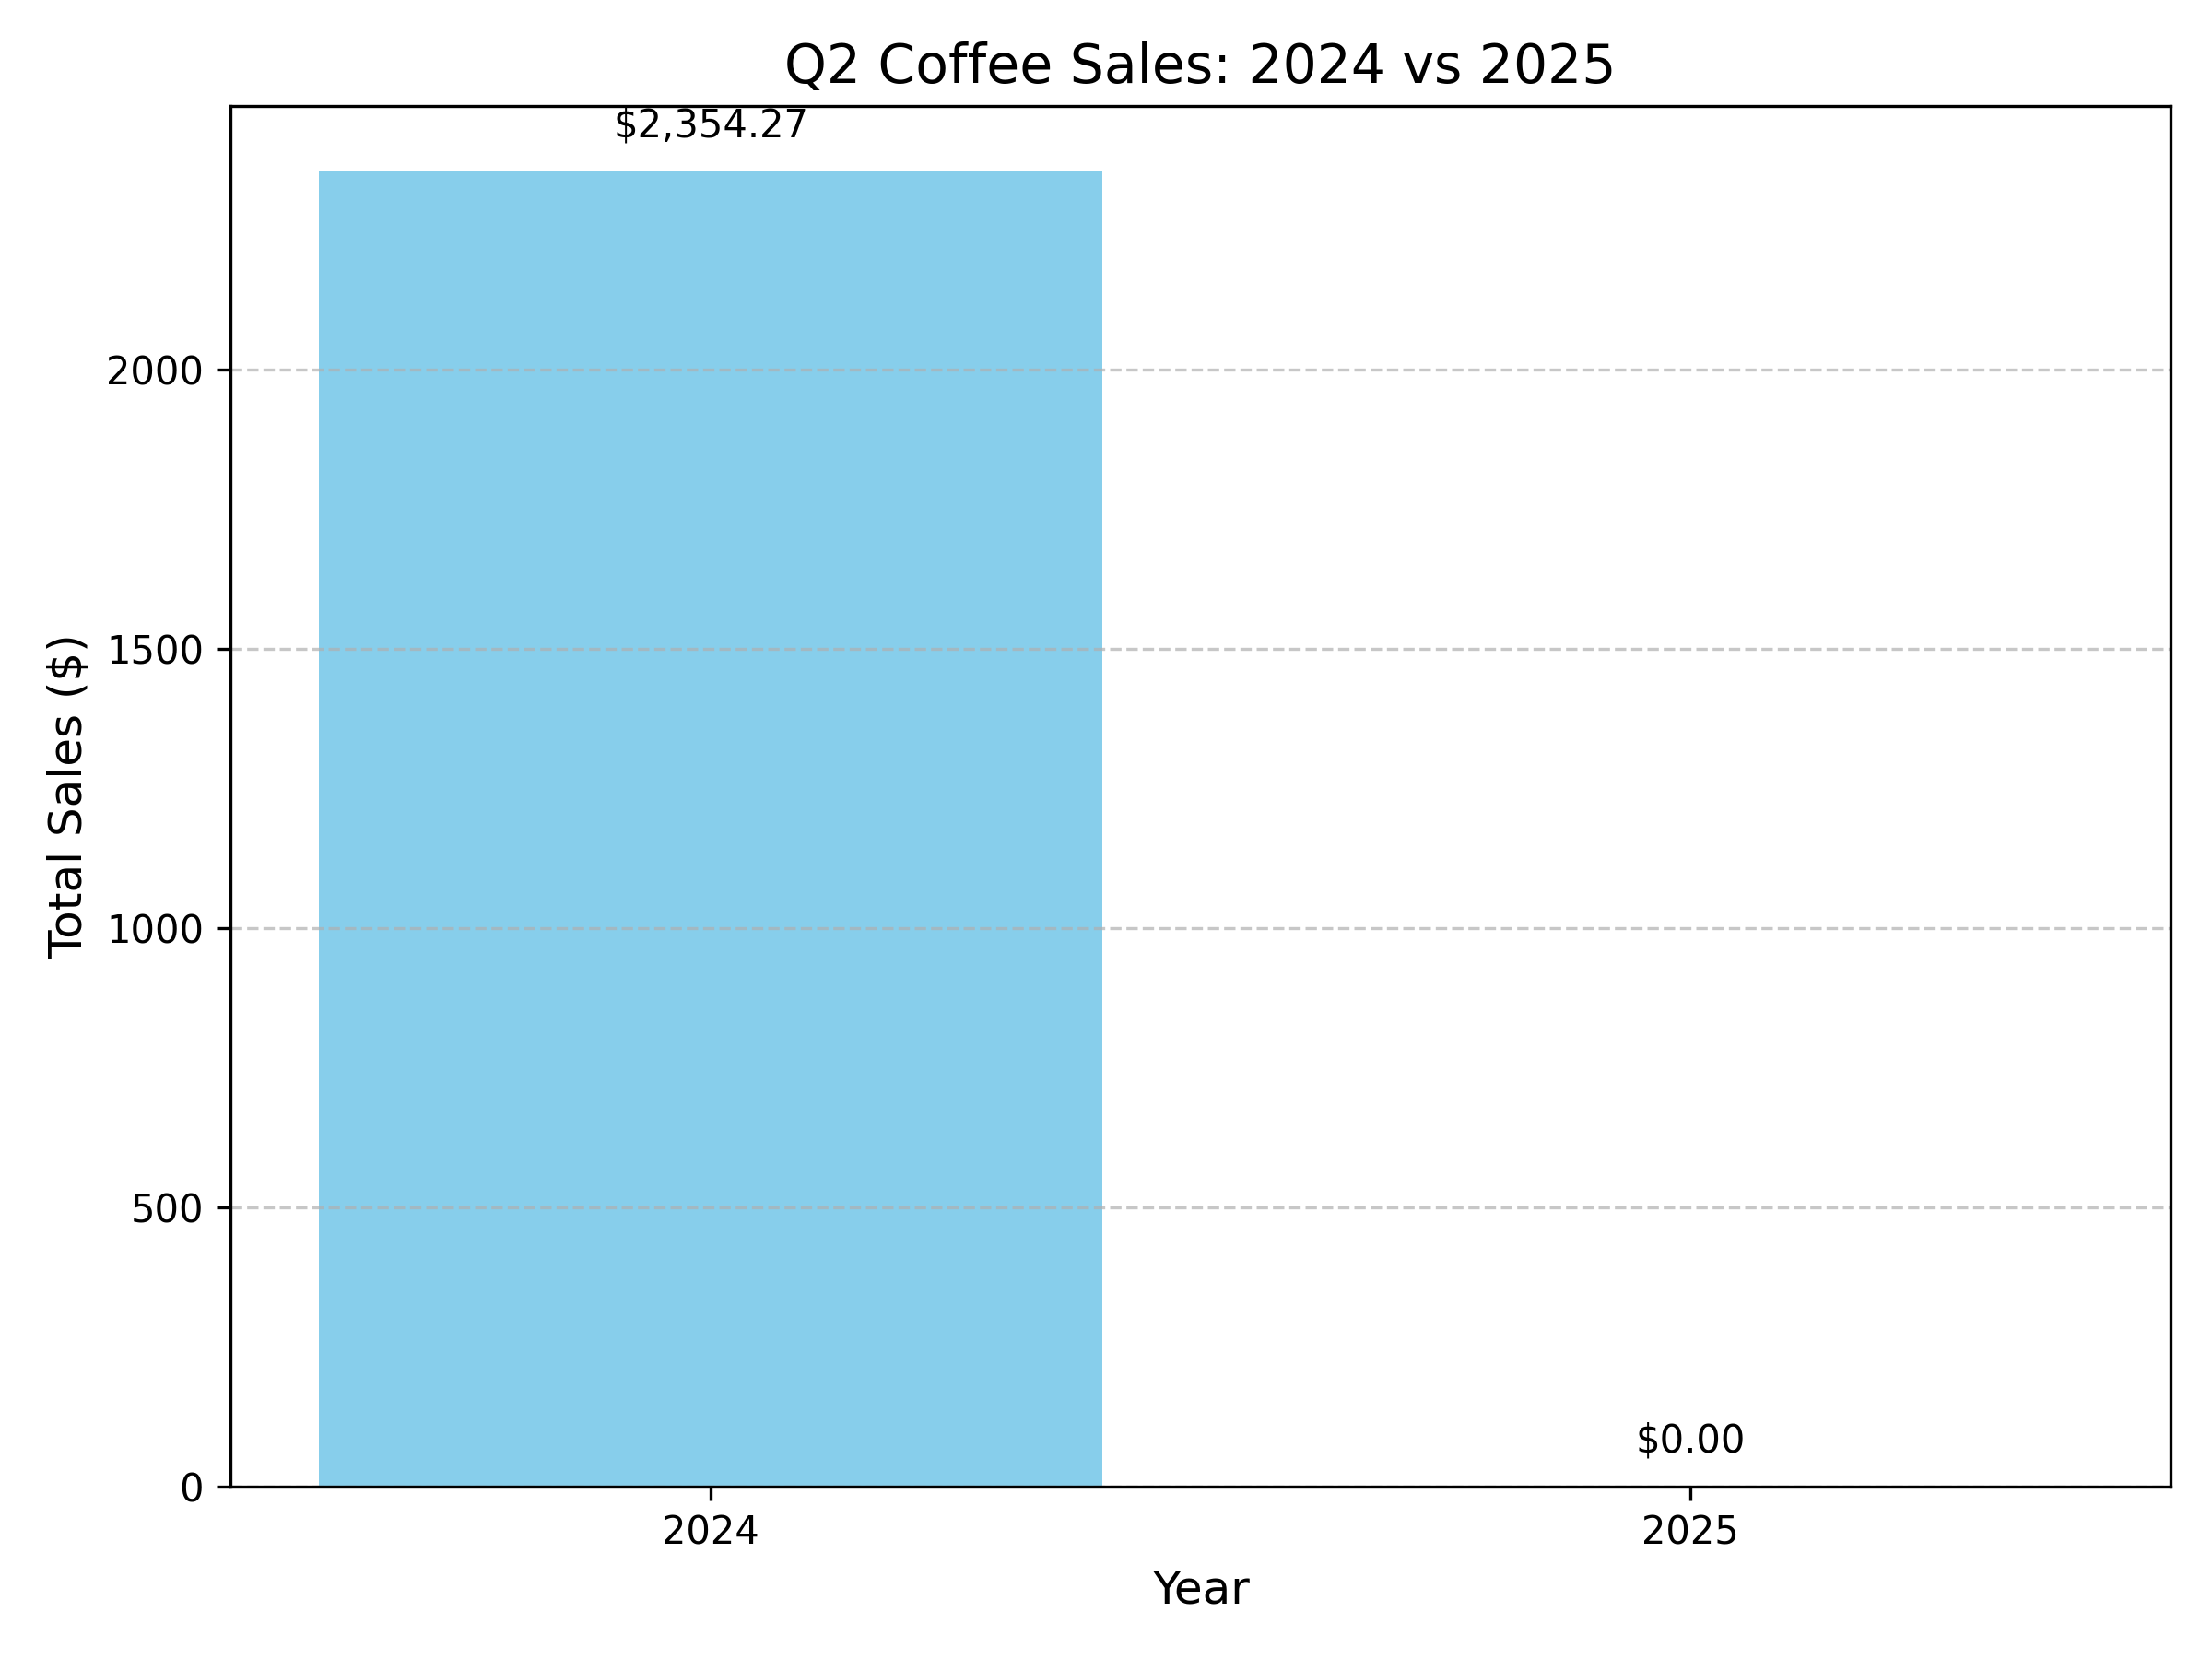

In [ ]:
# Here, insert your updates
user_instruction="Create a plot comparing Q2 coffee sales in 2024 and 2025 using the data in coffee_sales.csv."
generation_model="gemini-2.5-flash"
reflection_model="gemini-2.5-flash"
image_basename="drink_sales"

# Run the complete agentic workflow
_ = run_workflow(
    dataset_path="coffee_sales.csv",
    user_instruction=user_instruction,
    generation_model=generation_model,
    reflection_model=reflection_model,
    image_basename=image_basename
)